In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('paper_style.mplstyle')
import mtbvartools as vt
from mtbvartools.vcf import filterDataFrame
from tqdm import tqdm
from Bio import Phylo
from treeplot import TreePlot

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

## EspACD upstream region map

In [4]:
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
annotated_calls = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

open_events = vt.CallBytestream(
    event_vcb_path, True, False)

# write upstream events to check them out
call_dataframe = pd.read_csv(
    annotated_calls, index_col=['pos', 'ref', 'alt'])
call_df_slice = call_dataframe.loc[np.all([
    call_dataframe.index.get_level_values('pos') >= 4056360,
    call_dataframe.index.get_level_values('pos') <= 4057780], axis=0)]

# get indexes for the two major deletion events
delA_idx = call_df_slice.index[call_df_slice.index.to_frame().pos == 4056663][0]
delB_idx = call_df_slice.index[call_df_slice.index.to_frame().pos == 4056945][0]

131.0


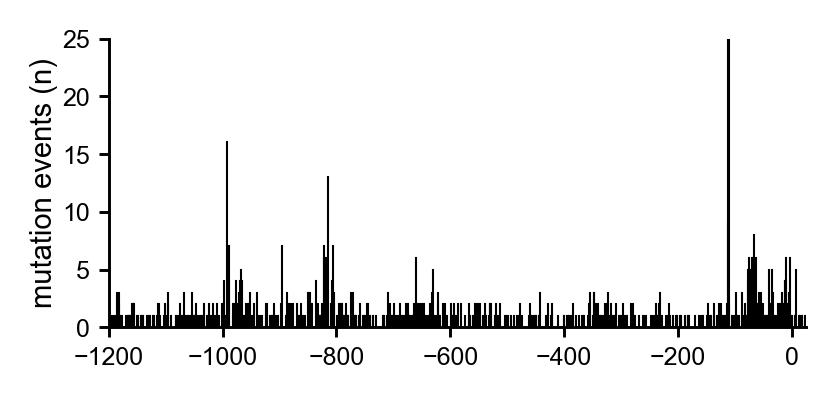

In [5]:
output_dir = 'outputs/figures'
output_name = '6C_espACD_upstream_variants.pdf'

left = 4056375 - 25
right = 4056375 + 1200
invert = True
relative_to = 4056375
maximum_size = 5

# get event indexes according to above constraints
event_indexes = pd.MultiIndex.from_tuples(open_events.calls.row, names=['pos', 'ref', 'alt'])
target_indexes = event_indexes[np.all([  # get target indexes
    event_indexes.get_level_values('pos') >= left,
    event_indexes.get_level_values('pos') <= right,
    event_indexes.get_level_values('alt').str.len() <= maximum_size,
    event_indexes.get_level_values('ref').str.len() <= maximum_size], axis=0)]

genomic_positions = np.arange(left, right + 1)
event_counts = np.zeros(len(genomic_positions))

for idx in target_indexes:
    event_counts[np.where(genomic_positions == idx[0])[0][0]] += np.sum(open_events.calls.loc[idx] != 0)

print(np.max(event_counts))

# edit x based on relative to and if to invert
relative_positions = genomic_positions - relative_to
if invert:
    relative_positions = relative_positions[::-1] * -1
    event_counts = event_counts[::-1]

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(3, 1.25))

for pos, ecount in zip(relative_positions, event_counts):
    if ecount == 0:
        continue
    ax.plot([pos, pos], [0, ecount], color='k', lw=0.5, rasterized=True)

ax.set_xlim(relative_positions[0], relative_positions[-1])
ax.set_ylim(0, 25)

ax.set_ylabel('mutation events (n)')

sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

position of INDELs, binding sites

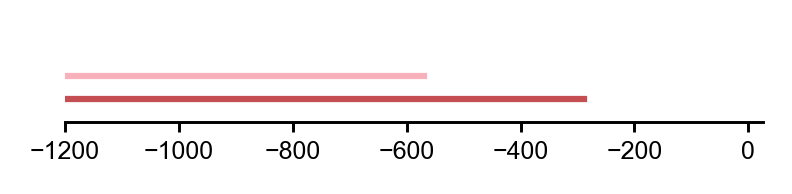

In [9]:
output_dir = 'outputs/figures'
output_name = '6C_deletion_positions.pdf'

left = 4056375 - 25
right = 4056375 + 1200
invert = True
relative_to = 4056375
maximum_size = 5

genomic_positions = np.arange(left, right + 1)

# edit x based on relative to and if to invert
relative_positions = genomic_positions - relative_to
if invert:
    relative_positions = relative_positions[::-1] * -1
    event_counts = event_counts[::-1]

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(3, .4))

# Plot RD8 like deletions
delA_extent = -1 * np.asarray([4056663 - relative_to, 4056663 - relative_to + len(delA_idx[1]) - 1])
delB_extent = -1 * np.asarray([4056945 - relative_to, 4056663 - relative_to + len(delB_idx[1]) - 1])
ax.plot(
    delA_extent,
    np.zeros(2) + 1, color=colors['dred'])
ax.plot(
    delB_extent,
    np.zeros(2) + 2, color=colors['lred'])


ax.set_xlim(relative_positions[0], relative_positions[-1])
ax.set_ylim(0, 4)
ax.set_yticks([])

sns.despine(left=True)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## EspACD up compared to intergeneic region rate

In [2]:
annotated_calls = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

In [3]:
## Prepare mask
# use masks to ignore poor quality sites and regions
max_mask_path = 'datasets/rlc_plus_lowmap_marin.bed'
miss_threshold = 0.10

genome_len = 4411532
n_samples = 55260

# get max's mask for bad sites
max_mask = vt.bedToMask(  # ignore positions in Max's mask
    max_mask_path, genome_len)

# generate a missing data mask
miss_mask = np.load('datasets/global_miss_counts.npz')['miss_counts'] / n_samples > miss_threshold

# generate a gene mask (only want to look at intergenic regions)
gene_table = pd.read_csv('datasets/gt_mtb_h37rv.csv', index_col=0)
genic_mask = np.zeros(genome_len).astype(bool)
for gid, gdata in gene_table.iterrows():
    genic_mask[gdata.start:gdata.end] = True

# combined mask
combined_mask = np.any([
    max_mask, miss_mask, genic_mask], axis=0) 

In [5]:
## get SNPs 
# load only intergenic SNPs
call_dataframe = pd.read_csv(
    annotated_calls, index_col=['pos', 'ref', 'alt'])
intergenic_snps_df = call_dataframe.loc[
    call_dataframe.loc[:, 'inside'].astype(str) == 'nan',  # intergenic
    call_dataframe.index.to_frame().ref.str.len() == 1,
    call_dataframe.index.to_frame().alt.str.len() == 1, :]

# write event counts to a genome length array
genome_length = 4411532
ig_event_counts = np.zeros(genome_length, dtype=int)
for idx, steps in tqdm(intergenic_snps_df.steps.items()):
    ig_event_counts[idx[0] - 1] += steps

152856it [00:00, 3766512.93it/s]


In [6]:
window_size = 11
# get convolved events for the whole genome
convolved_events = np.convolve(
    ig_event_counts, np.ones(window_size, dtype=int), 'valid')
# get mask sum 
convolved_mask = np.convolve(
    combined_mask, np.ones(window_size, dtype=int), 'valid')
# keep only windows where no part of window was masked
window_sums = convolved_events[
    convolved_mask == 0]

In [7]:
site_event = np.sum(ig_event_counts[4057366 - 5:4057366 + 6])
site_mask = np.sum(combined_mask[4057366 - 5:4057366 + 6])
print('4057367 events, mask sum, fraction:',
      site_event, site_mask, np.sum(window_sums < site_event) / len(window_sums))

site_event = np.sum(ig_event_counts[4057189 - 5:4057189 + 6])
site_mask = np.sum(combined_mask[4057189 - 5:4057189 + 6])
print('4057190 events, mask sum, percent:',
      site_event, site_mask, np.sum(window_sums < site_event) / len(window_sums))

4057367 events, mask sum, fraction: 31 0 0.9959145484876422
4057190 events, mask sum, percent: 25 0 0.9939966635936608


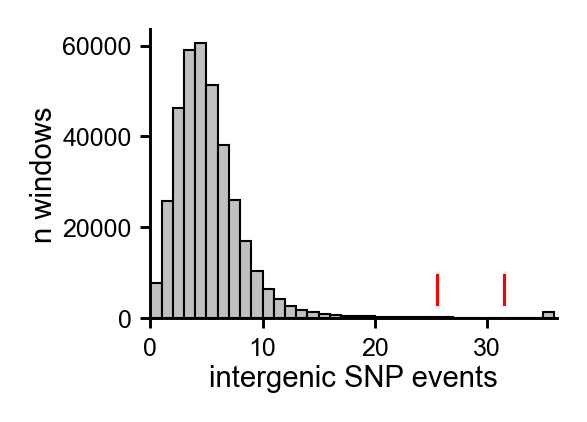

In [11]:
output_dir = 'outputs/figures'
output_name = '6D_intergenic_event_histogram.pdf'
ceiling = 36

fig, ax = plt.subplots(
    1, 1, figsize=(1.75, 1.25))

ceil_window_sums = window_sums.copy()
ceil_window_sums[window_sums > ceiling] = ceiling
# make a boxplot
ax.hist(
    ceil_window_sums,
    bins=ceiling,
    range=(0, ceiling),
    facecolor='silver',
    edgecolor='k',
    linewidth=0.5)

ax.axvline(25 + 0.5, 0.05, 0.15, lw=0.75, c='r')
ax.axvline(31 + 0.5, 0.05, 0.15, lw=0.75, c='r')

ax.set_xlim(0, ceiling + .25)
ax.set_xlabel('intergenic SNP events')
ax.set_ylabel('n windows')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## Strain with Site B variant (VCI_546)

In [2]:
tree = vt.loadTree(
    'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk')

target_node = tree.find_node_with_label('vci_546').parent_node.parent_node.parent_node

leaves_to_keep = {leaf.label for leaf in target_node.leaf_nodes()}
leaves_to_prune = {leaf.label for leaf in tree.leaf_nodes()} - leaves_to_keep

tree.reroot_at_node(target_node)
tree.prune_taxa_with_labels(leaves_to_prune)
tree.write(path='tmp/pruned_tree.nwk', schema='newick')

In [3]:
# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()

# load the tree
tree_path = 'tmp/pruned_tree.nwk'
tree = Phylo.read(tree_path, 'newick')

warning, root not found


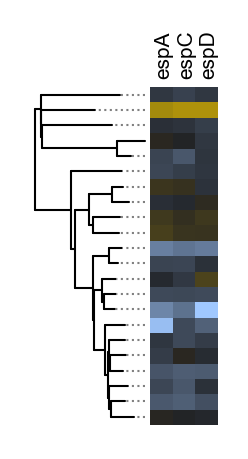

In [5]:
output_dir = 'outputs/figures'
output_name = '6E_espACD_upstream_site.pdf'

# load in the phylogenetic tree
tree_plot = TreePlot(
    phylo_obj=tree,
    root_name='canettii',
    offset_first=0.025)
# plot the tree
tree_plot.plotTree(
    figsize=(0.5, 1.5),
    tree_context={'lines.linewidth': 0.5})

# colormap
colormap = sns.diverging_palette(
    250, 70, s=120, l=80, as_cmap=True, center='dark')

block_width = 0.15

####
# plot a set of genes by z-score
target_genes = [
    ('Rv3616c', 'espA'),
    ('Rv3615c', 'espC'),
    ('Rv3614c', 'espD'),]
#
target_exp_M = rel_exp_by_strain.loc[
    :, np.asarray(target_genes).T[0]]
target_Z_M = target_exp_M / target_exp_M.std(axis=0)

ax = tree_plot.addHeatmap(
    width=len(target_genes) * block_width, input_data=target_Z_M,
    cmap=colormap, cbar=False, rasterized=True,
    vmin=-3, vmax=3,)
ax.set_xticks(
    np.arange(len(target_genes)) + 0.2, labels=np.asarray(target_genes).T[1])
ax.tick_params(
    top=True, bottom=False, labeltop=True, labelbottom=False, length=0, pad=1, labelsize=5)
plt.setp(ax.get_xticklabels(), rotation=90, ha="left") # rotation_mode="anchor")
ax.set_ylabel('')
####

plt.savefig(
    f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Cumulative espACD upstream variants

In [71]:
annotated_calls_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'Site A': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'Site B': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'Deletion A': anno_calls.index[
        pos_vector == 4056663],
    'Deletion B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes]

pastml_version  \
pos     ref                                                alt                        
4057189 C                                                  T                 1.9.43   
4057190 G                                                  A                 1.9.43   
                                                           T                 1.9.43   
4057191 G                                                  T                 1.9.43   
                                                           C                 1.9.43   
4057192 CAGTGCTACATGC                                      C                 1.9.43   
4057193 AGTGCTACATG                                        A                 1.9.43   
4057194 G                                                  T                 1.9.43   
        GT                                                 G                 1.9.43   
4057195 T                                                  C                 1.9.43   
4057363 G                                                  A                 1.9.43   
                                                           T                 1.9.43   
4057364 T                                                  C                 1.9.43   
4057367 C                                                  A                 1.9.43   
                                                           T                 1.9.43   
4057368 T                                                  C                 1.9.43   
4057369 A                                                  C                 1.9.43   
4057370 T                                                  TGTTTCTAT         1.9.43   
4057372 G                                                  A                 1.9.43   
4056663 TTCGATCGGTATGAGATCTGTTGCAGGAGAGTCTATATAGTGTGCTC... T                 1.9.43   
4056945 AATCCGTTGCGCTCGGCAAGATCGGCGAAGTATTGCGGCGGCCTTAT... A                 1.9.43   

                                                                      character  \
pos     ref                                                alt                    
4057189 C                                                  T                  3   
4057190 G                                                  A                  4   
                                                           T                  5   
4057191 G                                                  T                  6   
                                                           C                  7   
4057192 CAGTGCTACATGC                                      C                  8   
4057193 AGTGCTACATG                                        A                  9   
4057194 G                                                  T                 10   
        GT                                                 G                 11   
4057195 T                                                  C                 12   
4057363 G                                                  A                 39   
                                                           T                  0   
4057364 T                                                  C                  1   
4057367 C                                                  A                  2   
                                                           T                  3   
4057368 T                                                  C                  4   
4057369 A                                                  C                  5   
4057370 T                                                  TGTTTCTAT          6   
4057372 G                                                  A                  7   
4056663 TTCGATCGGTATGAGATCTGTTGCAGGAGAGTCTATATAGTGTGCTC... T                 12   
4056945 AATCCGTTGCGCTCGGCAAGATCGGCGAAGTATTGCGGCGGCCTTAT... A                 28   

                                                                      num_nodes  \
pos     ref                                                alt            

In [72]:
# one concerning mismatch between steps and transitions to alt
anno_calls.loc[(4057367, 'C', 'A')]

pastml_version                      1.9.43
character                                2
num_nodes                           110431
num_scenarios                           16
num_states_per_node_avg           1.000036
num_tips                             55260
num_unresolved_nodes                     4
percentage_of_unresolved_nodes    0.003622
steps                                   15
method                            DOWNPASS
ref_count                            53027
transitions_to_ref                       0
reversions_to_ref                        0
alt_count                             1081
transitions_to_alt                      14
reversions_to_alt                        0
miss_count                            1152
inside                                 NaN
dinside                                NaN
left                               Rv3616c
dleft                               -992.0
right                               Rv3617
dright                               366.0
Name: (4057

In [73]:
# preload a matrix shape (Nodes x Variants) recording if ALT (variants VCB) or R>A (events VCB) in any of the above three categories is detected
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
variant_vcb_path = 'datasets/variants/global/241104_variant_calls.vcb'

# for events
open_events = vt.CallBytestream(
    event_vcb_path, True, True)
events_data = {}
for site, indexes in target_indexes.items():
    events_data[site] = np.any(
        np.asarray([open_events.calls.loc[i] for i in indexes]) == 1, axis=0)
target_events_df = pd.DataFrame(
    data=events_data,
    index=open_events.calls.col)

# for variants
open_variants = vt.CallBytestream(
    variant_vcb_path, True, True)
variants_data = {}
for site, indexes in target_indexes.items():
    variants_data[site] = np.any(
        np.asarray([open_variants.calls.loc[i] for i in indexes]) == 1, axis=0)
target_variants_df = pd.DataFrame(
    data=variants_data,
    index=open_variants.calls.col)

In [74]:
tree = vt.loadTree(
    'datasets/variants/global/241104_ancestor_calls.vcb/tree.nwk')

### Lineage 1

In [75]:
root_node = 'internal4119'
output_dict = {}
cumulative_explained = []
for node in tqdm(list(tree.find_node_with_label(root_node).preorder_iter())):
    # check if any R>A events at node
    any_events = np.any(target_events_df.loc[
        node.label, :])
    if any_events:
        # store event categories
        event_categories = target_events_df.columns[target_events_df.loc[
            node.label, :]]
        # get leaves of the node
        leaves = [ln.label for ln in node.leaf_nodes()]
        
        # for each leaf, check that it is ALT at at least one of the defined categories
        is_variant_leaf = np.any(
            target_variants_df.loc[leaves, event_categories], axis=1)
        explained_leaves = is_variant_leaf.index[is_variant_leaf]
        
        # remove leaves that already have been explained by a parent node
        newly_explained_leaves = np.setdiff1d(explained_leaves, cumulative_explained)
        cumulative_explained += list(newly_explained_leaves)
        output_dict[node.label] = {
            'event_category':','.join(event_categories),
            'new':len(newly_explained_leaves),
            'all':len(explained_leaves),
            'tip_dist':node.distance_from_tip() + node.edge_length / 2}

# get total fraction of strains with target variant calls
leaf_labels = [ln.label for ln in tree.find_node_with_label(root_node).leaf_nodes()]

is_variant = np.any(
    target_variants_df.loc[leaf_labels], axis=1)
print(is_variant.sum() / len(leaf_labels), is_variant.sum(), len(leaf_labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8239/8239 [00:00<00:00, 47330.20it/s]

0.554368932038835 2284 4120


In [81]:
target_variants_df.loc[leaf_labels].loc[np.any(target_variants_df.loc[leaf_labels], axis=1)].index

Index(['SAMEA5228933', 'SAMEA7315219', 'SAMEA1119517', 'SAMEA1118378',
       'SAMEA112799232', 'SAMN09090425', 'SAMEA112799392', 'SAMEA112804112',
       'SAMEA112799161', 'SAMEA112800073',
       ...
       'SAMN06092019', 'SAMEA2535097', 'SAMEA112799483', 'SAMN06055547',
       'SAMN06055758', 'SAMEA11225749', 'SAMN06092003', 'SAMN06055669',
       'SAMN07766189', 'SAMN08214806'],
      dtype='object', length=2284)

In [84]:
len(cumulative_explained)

2283

variant 55.4%, not variant 44.6%


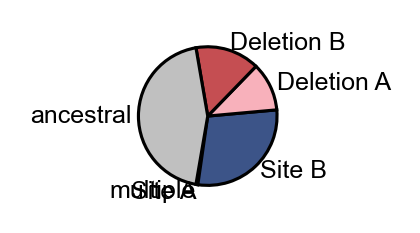

In [104]:
output_dir = 'outputs/figures'
output_name = '6F_L1_espACD_pie.pdf'

pie_variants_df = target_variants_df.loc[leaf_labels]
pie_variants_df.loc[:, 'multiple'] = False
multiple_idx = pie_variants_df.loc[np.sum(target_variants_df, axis=1) > 1].index
pie_variants_df.loc[multiple_idx, :] = False
pie_variants_df.loc[multiple_idx, 'multiple'] = True
# summing
total_variants = pie_variants_df.sum(0)
fraction_variant = pie_variants_df.values.sum() / len(leaf_labels)
total_variants.loc['ancestral'] = len(leaf_labels) - pie_variants_df.values.sum()
total_variants = total_variants.loc[['multiple', 'Site A', 'Site B', 'Deletion A', 'Deletion B', 'ancestral']]
print(f'variant {fraction_variant*100:.1f}%, not variant {(1-fraction_variant)*100:.1f}%')

fig, ax = plt.subplots(1, 1, figsize=(0.75, 0.75))
ax.pie(
    total_variants.values,
    labels=total_variants.index,
    colors=['black', colors['lblue'], colors['dblue'], colors['lred'], colors['dred'], colors['gray']],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.75},
    startangle=-fraction_variant*360/2,)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

23


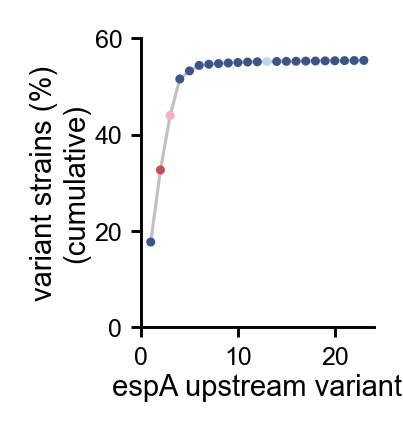

In [64]:
output_dir = 'outputs/figures'
output_name = '6F_L1_espACD.pdf'

color_dict = {
    'Deletion A': colors['lred'],
    'Deletion B': colors['dred'],
    'Site A': colors['lblue'],
    'Site B': colors['dblue']}


# convert to dataframe
plot_df = pd.DataFrame(
    output_dict).T
# remove nodes that did not add any new variants
plot_df = plot_df.loc[plot_df.loc[:, 'new'] != 0]
# sort in order of number of new variants
plot_df = plot_df.sort_values('new', ascending=False)
plot_df.loc[:, 'cumsum'] = plot_df.loc[:, 'new'].cumsum()
plot_df.loc[:, 'cumfraction'] = plot_df.loc[:, 'cumsum'] / len(tree.find_node_with_label(root_node).leaf_nodes()) * 100

print(len(plot_df))

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(1, 1.25))

ax.scatter(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    marker='o',
    lw=0.75,
    color=plot_df.event_category.map(color_dict).values,
    zorder=2,
    s=2)

ax.plot(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    lw=0.75,
    color='silver',
    zorder=0)

ax.set_ylim(0, 60)
ax.set_xlim(0, len(plot_df)+1)
# ax.set_xticks([0, 15, 30])

ax.set_ylabel('variant strains (%)\n(cumulative)')
ax.set_xlabel('espA upstream variant')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)